
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # returning the given data to the model
    return states, next_states, actions

In [7]:
# G: Generator/Predictor for generating/predicting the current action and next state
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))
        logits_states, logits_actions = tf.split(axis=1, num_or_size_splits=[state_size, action_size], value=logits)
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits_states, logits_actions

In [8]:
# D: Descriminator/Reward function
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing/merging states and actions
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [9]:
def model_loss(states, actions, next_states, # model data 
               action_size, hidden_size, state_size): # model init
    
    # Generator or predictor
    next_states_logits, actions_logits = generator(states=states, state_size=state_size, action_size=action_size, 
                                                   hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    d_logits_fake = discriminator(states=next_states_logits, actions=actions_logits, hidden_size=hidden_size, 
                                  reuse=False)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    d_logits_real = discriminator(states=next_states, actions=actions_real, hidden_size=hidden_size, 
                                  reuse=True)
    
    # This for the discriminator and for generator is the opposite
    # Min is 1+0 and max is 1+gamma*Qt+1
    # Assume Rt=1 0-1, 0 for fake and 1 for real
    d_labels_fake = tf.ones_like(d_logits_real) # d_logits_real for minimum is zero ~= 1
    d_labels_real = tf.ones_like(d_logits_real) + (0.99 * d_logits_real) # ~= d_logits_real 
    g_loss_fake = tf.reduce_mean(tf.square(d_logits_fake - d_labels_real)) # ~ Q_fake-Q_real
    g_loss_real = tf.reduce_mean(tf.square(d_logits_real - d_labels_fake)) # ~ Q_fake
    g_loss = g_loss_real + g_loss_fake
    d_loss_fake = tf.reduce_mean(tf.square(d_logits_fake - d_labels_fake)) # ~ = Q-1~=Q ~ Q_fake
    d_loss_real = tf.reduce_mean(tf.square(d_logits_real - d_labels_real)) # ~ = zero=1 ~ 0
    d_loss = d_loss_real + d_loss_fake

    #     # GAN: Adverserial training - G-learning
    #     d_labels_fake = tf.ones_like(d_logits_real) # d_logits_real for minimum is zero ~= 1
    #     #d_labels_real = tf.ones_like(d_logits_real) + (0.99 * d_logits_real) # ~= d_logits_real 
    #     d_labels_real = d_logits_real # ~= d_logits_real 
    #     #     d_labels_fake = tf.zeros_like(d_logits_real)
    #     #     d_labels_real = tf.ones_like(d_logits_real)
    #     g_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_real))
    #     g_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_fake))
    #     g_loss = g_loss_real + g_loss_fake

    #     # # GAN: Adverserial training - D-learning
    #     d_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    #     d_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    #     d_loss = d_loss_real + d_loss_fake

    # # Rewards fake/real
    # rewards_fake = tf.sigmoid(d_logits_fake)
    # rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, g_loss, d_loss

In [10]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [11]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions) # model input data

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [20]:
train_episodes = 1000           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [21]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list, d_loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss, d_loss = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # # Train the model
            # feed_dict = {model.states: states, model.next_states: next_states}
            # rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            # feed_dict={model.states: next_states}
            # next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # # Mean/average fake and real rewards or rewarded generated/given actions
            # rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            # rewards_real_mean = np.mean(rewards_real.reshape(-1))

            # # Set target_Qs to 0 for states where episode ends
            # episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            # next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # # Bellman equation: Qt = Rt + max(Qt+1)
            # targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 19.0 Training g_loss: 0.6799 Training d_loss: 1.1744 Explore P: 0.9981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 23.0 Training g_loss: 0.9024 Training d_loss: 1.0601 Explore P: 0.9959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 11.0 Training g_loss: 0.7506 Training d_loss: 1.0290 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 14.0 Training g_loss: 0.8431 Training d_loss: 1.0194 Explore P: 0.9934
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 17.0 Training g_loss: 3.0730 Training d_loss: 0.9691 Explore P: 0.9320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 17.0 Training g_loss: 3.7015 Training d_loss: 0.9664 Explore P: 0.9304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 22.0 Training g_loss: 3.6964 Training d_loss: 0.9668 Explore P: 0.9284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 16.0 Training g_loss: 4.9662 Training d_loss: 0.9623 Explore P: 0.9269
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 65 Total reward: 12.0 Training g_loss: 0.7157 Training d_loss: 0.9842 Explore P: 0.8740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 66 Total reward: 19.0 Training g_loss: 0.7590 Training d_loss: 0.9835 Explore P: 0.8724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 15.0 Training g_loss: 0.7480 Training d_loss: 0.9836 Explore P: 0.8711
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 22.0 Training g_loss: 0.7340 Training d_loss: 0.9837 Explore P: 0.8692
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 98 Total reward: 26.0 Training g_loss: 0.9639 Training d_loss: 0.9803 Explore P: 0.8048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 99 Total reward: 16.0 Training g_loss: 0.9609 Training d_loss: 0.9804 Explore P: 0.8035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 28.0 Training g_loss: 0.9704 Training d_loss: 0.9802 Explore P: 0.8013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 24.0 Training g_loss: 0.9660 Training d_loss: 0.9803 Explore P: 0.7994
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 130 Total reward: 32.0 Training g_loss: 0.9826 Training d_loss: 0.9828 Explore P: 0.7431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 131 Total reward: 19.0 Training g_loss: 0.9908 Training d_loss: 0.9818 Explore P: 0.7417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 132 Total reward: 80.0 Training g_loss: 0.9666 Training d_loss: 0.9805 Explore P: 0.7359
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 73.0 Training g_loss: 0.9725 Training d_loss: 0.9802 Explore P: 0.7306
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 162 Total reward: 29.0 Training g_loss: 0.9711 Training d_loss: 0.9802 Explore P: 0.6546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 57.0 Training g_loss: 0.9721 Training d_loss: 0.9802 Explore P: 0.6510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 33.0 Training g_loss: 0.9716 Training d_loss: 0.9802 Explore P: 0.6489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 43.0 Training g_loss: 0.9751 Training d_loss: 0.9801 Explore P: 0.6461
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 194 Total reward: 37.0 Training g_loss: 0.9817 Training d_loss: 0.9801 Explore P: 0.5824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 195 Total reward: 43.0 Training g_loss: 0.9883 Training d_loss: 0.9801 Explore P: 0.5800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 196 Total reward: 25.0 Training g_loss: 0.9996 Training d_loss: 0.9799 Explore P: 0.5786
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 197 Total reward: 47.0 Training g_loss: 1.0007 Training d_loss: 0.9800 Explore P: 0.5759
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 226 Total reward: 45.0 Training g_loss: 1.0214 Training d_loss: 0.9801 Explore P: 0.5137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 227 Total reward: 18.0 Training g_loss: 0.9945 Training d_loss: 0.9805 Explore P: 0.5128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 32.0 Training g_loss: 1.0993 Training d_loss: 0.9792 Explore P: 0.5112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 8.0 Training g_loss: 1.0872 Training d_loss: 0.9797 Explore P: 0.5108
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 258 Total reward: 17.0 Training g_loss: 0.9908 Training d_loss: 0.9801 Explore P: 0.4936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 259 Total reward: 13.0 Training g_loss: 0.9840 Training d_loss: 0.9802 Explore P: 0.4929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 260 Total reward: 8.0 Training g_loss: 0.9775 Training d_loss: 0.9803 Explore P: 0.4926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 261 Total reward: 12.0 Training g_loss: 0.9906 Training d_loss: 0.9803 Explore P: 0.4920
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 290 Total reward: 10.0 Training g_loss: 0.9786 Training d_loss: 0.9801 Explore P: 0.4768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 14.0 Training g_loss: 0.9738 Training d_loss: 0.9802 Explore P: 0.4761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 10.0 Training g_loss: 0.9875 Training d_loss: 0.9801 Explore P: 0.4756
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 10.0 Training g_loss: 1.0021 Training d_loss: 0.9799 Explore P: 0.4752
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 324 Total reward: 7.0 Training g_loss: 0.9868 Training d_loss: 0.9801 Explore P: 0.4592
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 13.0 Training g_loss: 0.9570 Training d_loss: 0.9804 Explore P: 0.4586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 9.0 Training g_loss: 0.9706 Training d_loss: 0.9802 Explore P: 0.4582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 12.0 Training g_loss: 0.9998 Training d_loss: 0.9799 Explore P: 0.4577
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 358 Total reward: 9.0 Training g_loss: 1.0052 Training d_loss: 0.9798 Explore P: 0.4416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 359 Total reward: 10.0 Training g_loss: 1.0037 Training d_loss: 0.9799 Explore P: 0.4411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 360 Total reward: 9.0 Training g_loss: 0.9840 Training d_loss: 0.9801 Explore P: 0.4407
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 17.0 Training g_loss: 0.9690 Training d_loss: 0.9802 Explore P: 0.4400
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 390 Total reward: 27.0 Training g_loss: 1.0204 Training d_loss: 0.9800 Explore P: 0.4268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 391 Total reward: 22.0 Training g_loss: 1.1188 Training d_loss: 0.9798 Explore P: 0.4259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 392 Total reward: 18.0 Training g_loss: 0.8734 Training d_loss: 0.9818 Explore P: 0.4251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 7.0 Training g_loss: 0.8895 Training d_loss: 0.9815 Explore P: 0.4248
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 422 Total reward: 15.0 Training g_loss: 0.9900 Training d_loss: 0.9800 Explore P: 0.4106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 423 Total reward: 15.0 Training g_loss: 0.9991 Training d_loss: 0.9799 Explore P: 0.4100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 424 Total reward: 9.0 Training g_loss: 1.0047 Training d_loss: 0.9799 Explore P: 0.4096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 425 Total reward: 8.0 Training g_loss: 1.0188 Training d_loss: 0.9797 Explore P: 0.4093
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 454 Total reward: 12.0 Training g_loss: 0.9957 Training d_loss: 0.9801 Explore P: 0.3963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 17.0 Training g_loss: 0.9941 Training d_loss: 0.9801 Explore P: 0.3957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 11.0 Training g_loss: 0.9860 Training d_loss: 0.9802 Explore P: 0.3953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 10.0 Training g_loss: 0.9803 Training d_loss: 0.9802 Explore P: 0.3949
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 487 Total reward: 13.0 Training g_loss: 0.9863 Training d_loss: 0.9800 Explore P: 0.3814
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 11.0 Training g_loss: 0.9899 Training d_loss: 0.9800 Explore P: 0.3810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 489 Total reward: 10.0 Training g_loss: 0.9958 Training d_loss: 0.9800 Explore P: 0.3806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 490 Total reward: 8.0 Training g_loss: 0.9939 Training d_loss: 0.9800 Explore P: 0.3803
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 519 Total reward: 8.0 Training g_loss: 1.0566 Training d_loss: 0.9797 Explore P: 0.3690
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 8.0 Training g_loss: 1.0169 Training d_loss: 0.9800 Explore P: 0.3687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 521 Total reward: 9.0 Training g_loss: 1.0084 Training d_loss: 0.9800 Explore P: 0.3684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 522 Total reward: 10.0 Training g_loss: 0.9973 Training d_loss: 0.9800 Explore P: 0.3681
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 552 Total reward: 10.0 Training g_loss: 1.0212 Training d_loss: 0.9797 Explore P: 0.3560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 553 Total reward: 11.0 Training g_loss: 1.0299 Training d_loss: 0.9796 Explore P: 0.3556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 8.0 Training g_loss: 1.0244 Training d_loss: 0.9797 Explore P: 0.3553
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 8.0 Training g_loss: 1.0046 Training d_loss: 0.9800 Explore P: 0.3550
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 585 Total reward: 11.0 Training g_loss: 0.9912 Training d_loss: 0.9800 Explore P: 0.3438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 9.0 Training g_loss: 0.9922 Training d_loss: 0.9800 Explore P: 0.3435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 587 Total reward: 11.0 Training g_loss: 0.9952 Training d_loss: 0.9800 Explore P: 0.3431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 11.0 Training g_loss: 0.9844 Training d_loss: 0.9800 Explore P: 0.3427
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 618 Total reward: 10.0 Training g_loss: 1.0050 Training d_loss: 0.9799 Explore P: 0.3319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 619 Total reward: 9.0 Training g_loss: 1.0174 Training d_loss: 0.9798 Explore P: 0.3316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 620 Total reward: 10.0 Training g_loss: 1.0124 Training d_loss: 0.9799 Explore P: 0.3313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 621 Total reward: 10.0 Training g_loss: 1.0059 Training d_loss: 0.9799 Explore P: 0.3310
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 651 Total reward: 12.0 Training g_loss: 0.9831 Training d_loss: 0.9801 Explore P: 0.3216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 13.0 Training g_loss: 0.9992 Training d_loss: 0.9799 Explore P: 0.3212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 10.0 Training g_loss: 1.0097 Training d_loss: 0.9798 Explore P: 0.3208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 10.0 Training g_loss: 1.0009 Training d_loss: 0.9799 Explore P: 0.3205
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 683 Total reward: 9.0 Training g_loss: 0.9868 Training d_loss: 0.9803 Explore P: 0.3115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 684 Total reward: 22.0 Training g_loss: 0.9844 Training d_loss: 0.9804 Explore P: 0.3108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 25.0 Training g_loss: 1.1303 Training d_loss: 0.9790 Explore P: 0.3101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 15.0 Training g_loss: 1.0367 Training d_loss: 0.9805 Explore P: 0.3096
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 715 Total reward: 42.0 Training g_loss: 1.0036 Training d_loss: 0.9799 Explore P: 0.2874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 29.0 Training g_loss: 1.0003 Training d_loss: 0.9799 Explore P: 0.2866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 64.0 Training g_loss: 1.0055 Training d_loss: 0.9799 Explore P: 0.2848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 718 Total reward: 26.0 Training g_loss: 1.0129 Training d_loss: 0.9798 Explore P: 0.2841
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 747 Total reward: 65.0 Training g_loss: 0.9852 Training d_loss: 0.9800 Explore P: 0.2609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 29.0 Training g_loss: 1.0067 Training d_loss: 0.9799 Explore P: 0.2602
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 749 Total reward: 22.0 Training g_loss: 0.9783 Training d_loss: 0.9801 Explore P: 0.2596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 44.0 Training g_loss: 0.9905 Training d_loss: 0.9800 Explore P: 0.2585
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 779 Total reward: 13.0 Training g_loss: 1.5909 Training d_loss: 0.9793 Explore P: 0.2365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 63.0 Training g_loss: 1.1141 Training d_loss: 0.9797 Explore P: 0.2351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 781 Total reward: 51.0 Training g_loss: 1.0446 Training d_loss: 0.9799 Explore P: 0.2339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 782 Total reward: 41.0 Training g_loss: 0.9797 Training d_loss: 0.9803 Explore P: 0.2330
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 813 Total reward: 13.0 Training g_loss: 1.3365 Training d_loss: 0.9786 Explore P: 0.2068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 814 Total reward: 9.0 Training g_loss: 1.4310 Training d_loss: 0.9774 Explore P: 0.2067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 815 Total reward: 8.0 Training g_loss: 1.4113 Training d_loss: 0.9777 Explore P: 0.2065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 816 Total reward: 12.0 Training g_loss: 1.0539 Training d_loss: 0.9805 Explore P: 0.2063
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 847 Total reward: 9.0 Training g_loss: 0.9922 Training d_loss: 0.9800 Explore P: 0.2003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 9.0 Training g_loss: 0.9957 Training d_loss: 0.9800 Explore P: 0.2001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Total reward: 9.0 Training g_loss: 0.9884 Training d_loss: 0.9800 Explore P: 0.2000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 13.0 Training g_loss: 0.9910 Training d_loss: 0.9800 Explore P: 0.1997
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 880 Total reward: 10.0 Training g_loss: 1.0253 Training d_loss: 0.9797 Explore P: 0.1937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 11.0 Training g_loss: 1.0267 Training d_loss: 0.9797 Explore P: 0.1935
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 10.0 Training g_loss: 1.0118 Training d_loss: 0.9798 Explore P: 0.1933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 9.0 Training g_loss: 1.0225 Training d_loss: 0.9797 Explore P: 0.1931
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 912 Total reward: 8.0 Training g_loss: 1.0951 Training d_loss: 0.9793 Explore P: 0.1885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 9.0 Training g_loss: 1.0631 Training d_loss: 0.9796 Explore P: 0.1883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 7.0 Training g_loss: 1.0455 Training d_loss: 0.9797 Explore P: 0.1882
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 9.0 Training g_loss: 1.0188 Training d_loss: 0.9800 Explore P: 0.1880
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 944 Total reward: 13.0 Training g_loss: 1.0888 Training d_loss: 0.9795 Explore P: 0.1828
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 10.0 Training g_loss: 1.0775 Training d_loss: 0.9795 Explore P: 0.1826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 12.0 Training g_loss: 1.0655 Training d_loss: 0.9797 Explore P: 0.1824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 13.0 Training g_loss: 1.0511 Training d_loss: 0.9797 Explore P: 0.1822
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 977 Total reward: 14.0 Training g_loss: 0.9883 Training d_loss: 0.9801 Explore P: 0.1770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 9.0 Training g_loss: 1.0009 Training d_loss: 0.9799 Explore P: 0.1768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 979 Total reward: 9.0 Training g_loss: 1.0013 Training d_loss: 0.9799 Explore P: 0.1767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 980 Total reward: 7.0 Training g_loss: 1.0082 Training d_loss: 0.9798 Explore P: 0.1766
---------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

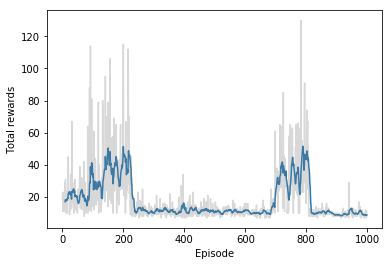

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

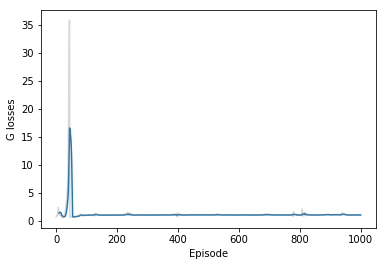

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

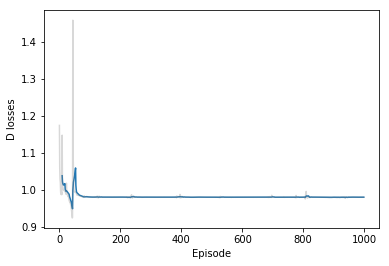

In [28]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.